In [1]:
#IMPORT for Training
import os
import numpy as np
import random
import itertools
import cv2 as cv
import pandas as pd
import time
from imageio.v2 import imread
from scipy.io import loadmat
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from typing import List, Tuple
import json



In [2]:
original_path = ""
imgPath       = original_path + "AllImages/"
folder_name   = original_path + "Dataset"
Saving_folder = original_path+ "Saving/"

Training_rate   = 0.80
validation_rate = 0.20

In [3]:
#Parameters
nb_epochs = 20
nb_classes = 81
batch_size = 32
with_early_stopping = False
IMAGE_SIZE = 180
colored = True
img_channels = 3 if colored else 1


We first define the function we need for our preprocessing

In [4]:
#-- Face detection
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt.xml')

#--Parameters for the detection
scaleFactor  = 1.05
minNeighbors = 6
minsize      = 100
# maxsize      = 700

def MyFaceDetectionFunction(img : np.ndarray) -> list:
    """Detect the face from an image
    
    return : a list of rectangles with coordinates (x,y,w,h)
     
    w is the width, h the height
    x and y are the coordonates of the top left corner of the rectangle
    """
    frame_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    #-- Detect faces
    faces = face_cascade.detectMultiScale(
        frame_gray, 
        scaleFactor  = scaleFactor, 
        minNeighbors = minNeighbors, 
        minSize      = (minsize, minsize),
        # maxSize    = (maxsize, maxsize)
    )
    return faces

#Since some images have more than two faces detected, we select the two biggest ones
def select_two_biggest_faces(faces : list) -> list:
    """
    Select the two biggest faces 
    
    input  : a list of rectangles with coordinates (x,y,w,h)
    
    return : a list of the two biggest faces with coordinates of top-left corner and bottom-right corner
    """
    areas = []
    M =[]
    for (x,y,w,h) in faces:
        x1 = x
        y1 = y
        x2 = x1 + w 
        y2 = y1 + h
        M.append([x1,y1,x2,y2])
        areas.append(w*h)
        
    if len(M)>2:
        first_face = 0
        second_face = 1
        if areas[first_face]<areas[second_face]: #check if the biggest face is on index 2, then swap index
            first_face, second_face = 1, 0
        for j in range(2,len(M)):
            if areas[j]>areas[first_face]:
                second_face = first_face
                first_face  = j
            elif areas[j]> areas[second_face]:
                second_face = j
        M = [M[first_face],M[second_face]]
    return M

def Save_detection(img : np.ndarray, faces : list, img_name : str) -> None:
    """Draw the rectangle on the original image and save the image in the saving folder
    
    Args:
        img (np.ndarray): the two biggest faces
        faces (list)    : list of coordinates of faces
        img_name (str)  : name of the image 
    """  
    for rect in faces:
        cv.rectangle(img,(rect[0],rect[1]),(rect[2],rect[3]),(0,0,255),4)
        
    cv.imwrite(Saving_folder + img_name, img)
    # cv.imshow(img)
    return
    
#Preprocessing of the Data
def process_image(img : np.ndarray) -> np.ndarray :
    """
    Change the color and normalize the images

    Args:
        img (np.ndarray): the two biggest faces

    Returns:
        np.ndarray: the two biggest faces preprocessed
    """
    img_resized = cv.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    if not colored:
        grey_img = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
        face_normalized = grey_img /255.0
        face = np.expand_dims(face_normalized, axis=-1) 
        return face

    else:
        colored_img = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)
        face_normalized = colored_img /255.0

        return face_normalized
    
def crop_and_normalize_image(img : np.ndarray, faces : list) -> list:
    """Crop the image according to the list of faces we have, and then 

    Args:
        img (np.ndarray): image
        faces (list): coordinates of faces

    Returns:
        list : list of images cropped and normalized
    """
    cropped_and_normalized_faces =[]
    for (x1, y1, x2, y2) in faces:
            face = img[y1:y2, x1:x2]
            processed_image = process_image(face)
            cropped_and_normalized_faces.append(processed_image)
            # cv.imwrite(Saving_folder + im, img_resized)
    return cropped_and_normalized_faces

def detect_crop_and_normalize_image(img : np.ndarray) :
    """Detects automatically the faces present in an image and apply the preprocessing
    if the image got a face

    Args:
        img (np.ndarray): image
        bool (_type_): _description_

    Returns:
        list : of cropped and normalized faces
        bool : have_a_face
    """
    # We apply face detection
    facesDetected = MyFaceDetectionFunction(img)
    cropped_and_normalized_faces=[]
    # We select the two biggest faces
    faces = select_two_biggest_faces(facesDetected)    
    have_a_face = len(faces)>0
    # Save_detection(img,faces,im)
    if have_a_face:
        #-- Handle images with detected faces
        have_a_face = True
        # Crop, normalize, and collect faces if detected
        cropped_and_normalized_faces = crop_and_normalize_image(img,faces)
    return cropped_and_normalized_faces,have_a_face


#this function use faces from matlab
def normalize_and_crop_faces(df : pd.DataFrame, directory : str , display : bool =False ):
    """normalize and crop faces but use list of coordinates of faces that already exist for our images
    
    Args:
        df (pd.DataFrame): dataset
        directory (str): directory of the images
        display (bool, optional : false): Display the grid with images

    Returns:
        list of cropped_and_normalized_faces;
        list of labels;
        list of image names
    """
    #-- parameters for the grid plot
    nDisplay = 3
    ncols = 3  
    nrows = 1
    imgDisplayed = 0
    plt.figure(figsize=(9,12))

    cropped_and_normalized_faces = []
    labels=[]
    image_names =[]
    for index, row in df.iterrows():
        filepath = os.path.join(directory, row['Image'])
        img = cv.imread(filepath)
        
        if img is not None:
            faces = row['Faces']
            have_a_face = len(faces) > 0   
            if have_a_face:
                images = crop_and_normalize_image(img,faces)
                for _ in range(len(faces)):
                    labels.append(row['Label'])
                    image_names.append(row['Image'])
                    
                # Crop, normalize, and collect faces if detected
                cropped_and_normalized_faces += images                
                if imgDisplayed<nDisplay and display:
                    plt.subplot(nrows, ncols, imgDisplayed+1)  # Create a subplot for each image
                    imgDisplayed +=1

                    
                    plt.imshow(images[0],cmap='gray')
                    plt.title(str(row['Image']).replace(".jpg","")+" with ID = "+ str(row['Label']))
                    plt.axis('off')
                        
            else:
                #-- Handle images without detected faces
                # Resize the original image and normalize
                cropped_and_normalized_faces.append(process_image(img))
                labels.append(row['Label'])
                image_names.append(row['Image'])

    plt.show()
    return np.array(cropped_and_normalized_faces), np.array(labels),np.array(image_names)


We load the dataset we added by ourselfs with its corresponding labels

In [5]:
#--import the new dataset

with open('new_data.json', 'r') as file:
    new_data = json.load(file)
print(len(new_data))    


1802


We load now the labels that we got from the lab

In [6]:
#We start loading the data
challenge = loadmat('AGC_Challenge3_Training.mat')
data      = challenge['AGC_Challenge3_TRAINING'][0]
data_extended = []

for item in data:
    label = item[0][0][0]
    image = item[1][0]
    # Handling faces, assuming faces data is in item[2]
    faces = item[2] if len(item[2]) > 0 else []
    data_extended.append([label, image, faces])

print(len(data_extended))

#add the new data 
data_extended += new_data

# Convert the extended list to a DataFrame
df_extended = pd.DataFrame(data_extended, columns=['Label', 'Image', 'Faces'])

print(len(new_data))

1200
1802


In [7]:
# Split the Dataset into Training Dataset and Validation Dataset
train_df, val_df = train_test_split(df_extended, test_size=validation_rate, random_state=42, stratify=df_extended['Label'])
train_df.head()


,Label,Image,Faces
2026,45,image_A1978.jpeg,"[[1018, 545, 1732, 1259]]"
1290,14,image_A1307.jpeg,"[[313, 46, 437, 170]]"
2192,52,image_A2127.jpeg,"[[50, 212, 660, 822]]"
118,20,image_A0119.jpg,"[[32, 39, 138, 145]]"
1801,38,image_A5162.jpeg,"[[151, 15, 258, 122]]"


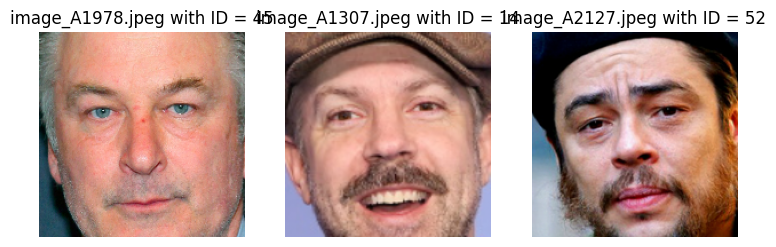

<Figure size 900x1200 with 0 Axes>

(2423, 180, 180, 3)
(2423,)
(604, 180, 180, 3)


In [8]:
##--TEST
Training_cropped_faces  , Training_face_labels  ,Training_image_names   = normalize_and_crop_faces(train_df, imgPath, display=True)
Validation_cropped_faces, Validation_face_labels,Validation_image_names = normalize_and_crop_faces(val_df, imgPath)
print(Training_cropped_faces.shape)
print(Training_face_labels.shape)
print(Validation_cropped_faces.shape)


In [9]:
#--additionnal_functions
def Count_images_per_label(label_val : list)-> list:
    """Count the number of images per label in our dataset

    Args:
        label_val (list): list of labels we got for our dataset

    Returns:
        list: of number of occurence for each label mentionned as an index
    """
    count_ = [0 for i in range(81)]
    for k in range(len(label_val)):
        label = label_val[k]
        if label ==-1:
            count_[0] +=1
        else:
            count_[label] +=1
    return(count_)

counter = Count_images_per_label(df_extended['Label'])
print(counter)


[720, 29, 13, 10, 11, 11, 10, 41, 40, 32, 42, 12, 27, 39, 30, 12, 12, 16, 30, 42, 38, 24, 33, 36, 14, 14, 50, 36, 16, 26, 14, 14, 35, 22, 52, 38, 30, 25, 52, 26, 27, 17, 39, 41, 49, 38, 22, 22, 15, 28, 30, 57, 26, 35, 15, 33, 32, 35, 35, 26, 18, 18, 37, 25, 4, 15, 42, 24, 33, 26, 57, 43, 25, 44, 36, 31, 25, 4, 46, 25, 28]


In [10]:
#CLASS DATASET
class dataset() :
    def __init__(self,Training_images, Training_labels,Validation_images, Validation_labels):
        self.X_train = Training_images
        self.X_valid = Validation_images
        self.Y_train = Training_labels
        self.Y_valid = Validation_labels

    def augment_image(self,image : np.ndarray)-> np.ndarray:
        """
        Apply random transformations to a single image to augment it.
        The input image is expected to be a NumPy array of shape (224, 224, 1).
        """
        # Convert single image to batch format by adding an extra dimension
        image_batch = np.expand_dims(image, axis=0)

        # Create an ImageDataGenerator instance for augmentation
        augmenter = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Generate augmented images (here, we generate a single one)
        augmented_image = next(augmenter.flow(image_batch, batch_size=5))

        # Remove batch dimension and return the augmented image
        return augmented_image[0]

    def augment_dataset(self,X, y, augmentation_factor=5):
        """
        Augment a dataset of images X with labels y, repeating the process 'augmentation_factor' times.
        Each original image will have 'augmentation_factor' augmented versions in the new dataset.
        """
        X_augmented = []
        y_augmented = []

        for i in range(len(X)):
            # Original image and label
            X_augmented.append(X[i])
            y_augmented.append(y[i])

            # Generate augmented images
            for _ in range(augmentation_factor):
                augmented_image = self.augment_image(X[i])
                X_augmented.append(augmented_image)
                y_augmented.append(y[i])  # Keep the same label for the augmented image

        return np.array(X_augmented), np.array(y_augmented)

    def read(self, nb_classes=nb_classes,img_size=IMAGE_SIZE, img_channels=img_channels):
        """preprocess the images of our dataset and prepare them for training
        """
        self.X_train = self.X_train.reshape(-1, img_size, img_size, img_channels)
        self.X_valid = self.X_valid.reshape(-1, img_size, img_size, img_channels)

        self.X_train = self.X_train.astype('float32')
        self.X_valid = self.X_valid.astype('float32')
        
        self.Y_train = self.Y_train - 1
        self.Y_valid = self.Y_valid - 1


        self.X_train,self.Y_train = self.augment_dataset(self.X_train,self.Y_train,1)
        print('X_train shape:', self.X_train.shape)
        print(self.X_train.shape[0], 'train samples')
        print(self.Y_train.shape[0], 'valid samples')
        
        # Convert class vectors to binary class matrices
        self.Y_train = to_categorical(self.Y_train, nb_classes)
        self.Y_valid = to_categorical(self.Y_valid, nb_classes)


In [11]:
data = dataset(Training_cropped_faces, Training_face_labels,Validation_cropped_faces, Validation_face_labels)
data.read()


X_train shape: (4846, 180, 180, 3)
4846 train samples
4846 valid samples


In [12]:
#-- We computed a F1 score to have an idea of its result during the training in real time
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Assuming y_pred are probabilities that need to be rounded to 0 or 1

        true_pos = tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1))
        false_pos = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1))
        false_neg = tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0))

        true_pos = tf.cast(true_pos, self.dtype)
        false_pos = tf.cast(false_pos, self.dtype)
        false_neg = tf.cast(false_neg, self.dtype)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            true_pos = tf.multiply(true_pos, sample_weight)
            false_pos = tf.multiply(false_pos, sample_weight)
            false_neg = tf.multiply(false_neg, sample_weight)

        self.true_positives.assign_add(tf.reduce_sum(true_pos))
        self.false_positives.assign_add(tf.reduce_sum(false_pos))
        self.false_negatives.assign_add(tf.reduce_sum(false_neg))

    def result(self):
        """ Computes the f1 score """
        f1_score = (2 * self.true_positives) / (2 * self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [24]:
#CLASS MODEL

class MyModel(object):
  def __init__(self) :
    self.model = None
  
  def build_model(self, dataset):
    input_shape = dataset.X_train.shape[1:]
    print(input_shape)

    inputs = Input(shape=input_shape)
    
    # Convolutional block 1
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional block 2
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    # Flatten and classification
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    
    outputs = Dense(nb_classes, activation='softmax')(x)  
    model = Model(inputs=inputs, outputs=outputs)
    self.model = model
    
  def train(self, dataset, batch_size=batch_size, nb_epoch=nb_epochs):
    self.model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    min_delta=0.0001,     # Minimum change to qualify as an improvement
    mode='min',          # The training will stop when the quantity monitored has stopped decreasing
    verbose=1,           # Output messages
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
    )
    
    self.model.fit(dataset.X_train, dataset.Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    callbacks = [early_stopping],
                    validation_data=(dataset.X_valid, dataset.Y_valid),
                    shuffle=True)
    
  def print_parameters(self):
    total_params = self.model.count_params()
    print("The model contain ",total_params, " parameters")

  def save(self, file_path):
      print('Model Saved.')
      self.model.save(file_path)


In [25]:

model = MyModel()
model.build_model(data)
total_params = model.print_parameters()

#-- Training 

# model.train(data)
# model_name = "modelV26.h5"
# model.save(model_name)

(180, 180, 3)
The model contain  706961  parameters


In [16]:
#-- Load model
model_path = 'modelV85.h5'
model = load_model(model_path)

total_params = model.count_params()
print("The model contain ",total_params, " parameters")


# Get the size in MB
size_model = os.path.getsize(model_path)/ (1024*1024)  
print(f"Size of the model is : {size_model:.2f} MB")

The model contain  707473  parameters
Size of the model is : 8.17 MB


In [17]:
def predict(model, image: np.ndarray)-> int:
    """predict the result of our face detection model on an image

    Returns:
        int: class
    """
    cropped_and_normalized_faces,have_a_face = detect_crop_and_normalize_image(image)
  
    if not have_a_face:
        return -1
    
    best_prediction = 0
    class_ = 0
    
    for face in cropped_and_normalized_faces:
        face_batch = np.expand_dims(face, axis=0)  # format the model to (1, 224, 224, 1)
        predictions = model.predict(face_batch,verbose=0)
        
        predicted_class = np.argmax(predictions, axis=1)
        val_prediction = np.max(predictions[0])
        
        if  val_prediction>best_prediction:
            best_prediction = predicted_class[0]
            class_ = predicted_class[0]
    if class_ ==0: 
        return -1
    else:
        return class_
  
  
im = "image_A0089.jpg"
img = cv.imread(imgPath+im)
prediction = predict(model,img)
print(prediction)


23


In [20]:
def CHALL_AGC_ComputeRecognScores(auto_ids, true_ids):
    #   Compute face recognition score
    #
    #   INPUTS
    #     - AutomSTR: The results of the automatic face
    #     recognition algorithm, stored as an integer
    #
    #     - AGC_Challenge_STR: The ground truth ids
    #
    #   OUTPUT
    #     - FR_score:     The final recognition score
    #
    #   --------------------------------------------------------------------
    #   AGC Challenge
    #   Universitat Pompeu Fabra
    #

    if len(auto_ids) != len(true_ids):
        assert ('Inputs must be of the same len');

    f_beta = 1
    res_list = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nTP = len([i for i in res_list if auto_ids[i] == true_ids[i]])

    res_list = list(filter(lambda x: auto_ids[x] != -1, range(len(auto_ids))))

    nFP = len([i for i in res_list if auto_ids[i] != true_ids[i]])

    res_list_auto_ids = list(filter(lambda x: auto_ids[x] == -1, range(len(auto_ids))))
    res_list_true_ids = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nFN = len(set(res_list_auto_ids).intersection(res_list_true_ids))

    FR_score = (1 + f_beta ** 2) * nTP / ((1 + f_beta ** 2) * nTP + f_beta ** 2 * nFN + nFP)

    return FR_score,nTP,res_list
    

In [21]:
#Computing F1 score
# Basic script for Face Recognition Challenge
# --------------------------------------------------------------------
# AGC Challenge
# Universitat Pompeu Fabra

# Load challenge Training data
dir_challenge3 = original_path
AGC_Challenge3_TRAINING = loadmat(dir_challenge3 + "AGC_Challenge3_Training.mat")
AGC_Challenge3_TRAINING = np.squeeze(AGC_Challenge3_TRAINING['AGC_Challenge3_TRAINING'])

imageName = AGC_Challenge3_TRAINING['imageName']
imageName = list(itertools.chain.from_iterable(imageName))

ids = list(AGC_Challenge3_TRAINING['id'])
ids = np.concatenate(ids).ravel().tolist()

faceBox = AGC_Challenge3_TRAINING['faceBox']
faceBox = list(itertools.chain.from_iterable(faceBox))


# Initialize results structure
AutoRecognSTR = []

# Initialize timer accumulator
total_time = 0

# Load your FRModel
my_FRmodel = model

for idx, im in enumerate(imageName):

    image = cv.imread(imgPath + im)
        

    try:
        print(f"Image number : {idx}", end='\r')  
        ti = time.time()
        # Timer on
        ###############################################################
        # Your face recognition function goes here.It must accept 2 input parameters:

        # 1. the input image A
        # 2. the recognition model

        # and must return a single integer number as output, which can be:

        # a) A number between 1 and 80 (representing one of the identities in the training set)
        # b) A "-1" indicating that none of the 80 users is present in the input image
        
        autom_id = predict(my_FRmodel, image)
        tt = time.time() - ti
        total_time = total_time + tt
    except:
        # If the face recognition function fails, it will be assumed that no user was detected for his input image
        autom_id = random.randint(-1, 80)

    AutoRecognSTR.append(autom_id)

FR_score ,nTP, res_list= CHALL_AGC_ComputeRecognScores(AutoRecognSTR, ids)
_, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print('F1-score: %.2f, Total time: %2d m %.2f s' % (100 * FR_score, int(minutes), seconds))

F1-score: 85.22, Total time:  1 m 27.32 s


In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 16)      448       
                                                                 
 re_lu_24 (ReLU)             (None, 178, 178, 16)      0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 89, 89, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 re_lu_25 (ReLU)             (None, 87, 87, 32)        0         
                                                           

In [23]:
print(f"The model has {len(model.layers)} layers.")

# Print the output shape of the last layer
print(f"The output shape of the last layer is: {model.layers[-1].output_shape}")

# If you want to see all layers despite the long list, you can iterate through them
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1}/{len(model.layers)} - {layer.name}: {layer.output_shape}")

The model has 18 layers.
The output shape of the last layer is: (None, 81)
Layer 1/18 - input_7: [(None, 180, 180, 3)]
Layer 2/18 - conv2d_24: (None, 178, 178, 16)
Layer 3/18 - re_lu_24: (None, 178, 178, 16)
Layer 4/18 - max_pooling2d_24: (None, 89, 89, 16)
Layer 5/18 - conv2d_25: (None, 87, 87, 32)
Layer 6/18 - re_lu_25: (None, 87, 87, 32)
Layer 7/18 - max_pooling2d_25: (None, 43, 43, 32)
Layer 8/18 - conv2d_26: (None, 41, 41, 32)
Layer 9/18 - re_lu_26: (None, 41, 41, 32)
Layer 10/18 - max_pooling2d_26: (None, 20, 20, 32)
Layer 11/18 - conv2d_27: (None, 18, 18, 64)
Layer 12/18 - re_lu_27: (None, 18, 18, 64)
Layer 13/18 - max_pooling2d_27: (None, 9, 9, 64)
Layer 14/18 - flatten_5: (None, 5184)
Layer 15/18 - dropout_3: (None, 5184)
Layer 16/18 - dense_4: (None, 128)
Layer 17/18 - batch_normalization_2: (None, 128)
Layer 18/18 - dense_5: (None, 81)
